In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
from os.path import join
import pickle
import json
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('../../style.mcstyle')   # noqa
import numpy as np
import torch
import seaborn as sns
import pandas as pd
import warnings
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'
abadir = join(wdir, 'abacus1gpch/correct/L1000-N128')
quidir = join(wdir, 'quijote/nbody/L1000-N128')

abaparams = pd.read_csv(
    '/home/x-mho1/git/ltu-cmass-run/params/abacus_cosmologies.txt', header=None, delimiter=' ')
abaparams = abaparams.iloc[130:181]
quiparams = pd.read_csv(
    '/home/x-mho1/git/ltu-cmass-run/params/latin_hypercube_params.txt', header=None, delimiter=' ')
quiparams = quiparams.iloc[:2000]

## Are we computing Pk right? (yes)

In [ ]:
from cmass.utils import cosmo_to_astropy


def get_all(file, a):
    with h5py.File(file, 'r') as f:
        pos, vel, mass = f[a]['pos'][()], f[a]['vel'][()], f[a]['mass'][()]
    return pos, vel, mass


def load_diag(file, a):
    o = {}
    with h5py.File(file, 'r') as f:
        for k, v in f[a].items():
            o[k] = np.array(v)
    return o


quiidx = 663
L = 1000
a = 1/(1+0.5)
a = f'{a:.6f}'
pos, vel, mass = get_all(join(quidir, str(quiidx), 'halos.h5'), a)

diag = load_diag(join(quidir, str(quiidx), 'diag/halos.h5'), a)

cosmo = quiparams.iloc[quiidx].values
cosmo = cosmo_to_astropy(cosmo)

### Real space

In [126]:
pos %= L

print(len(pos))
Ncut = 100_000
mask = np.argsort(mass)[-Ncut:]
pos = pos[mask]
vel = vel[mask]
mass = mass[mask]
print(len(pos))

671684
100000


In [127]:
Lnoise = (1000/128)/np.sqrt(3)  # Set by CHARM resolution
pos += np.random.randn(*pos.shape) * Lnoise

In [128]:
from cmass.diagnostics.summ import get_mesh_resolution
N, MAS = get_mesh_resolution(L, True)
print(N, MAS)

256 TSC


In [129]:
import MAS_library as MASL

pos = np.ascontiguousarray(pos)
delta = np.zeros((N, N, N), dtype=np.float32)
pos %= L
MASL.MA(pos, delta, BoxSize=L, MAS=MAS)
delta = delta.astype(np.float64)
delta /= np.mean(delta)
delta -= 1

In [ ]:
import Pk_library as PKL
axis = 0
threads = 1
Pk = PKL.Pk(delta.astype(np.float32), L, axis, MAS, threads, verbose=False)
k = Pk.k3D
Pk = Pk.Pk
print(k.shape, Pk.shape)

(221,) (221, 3)


[Text(0.5, 0, '$k$ [h/Mpc]'), Text(0, 0.5, '$P(k) / P_{diag}(k)$')]

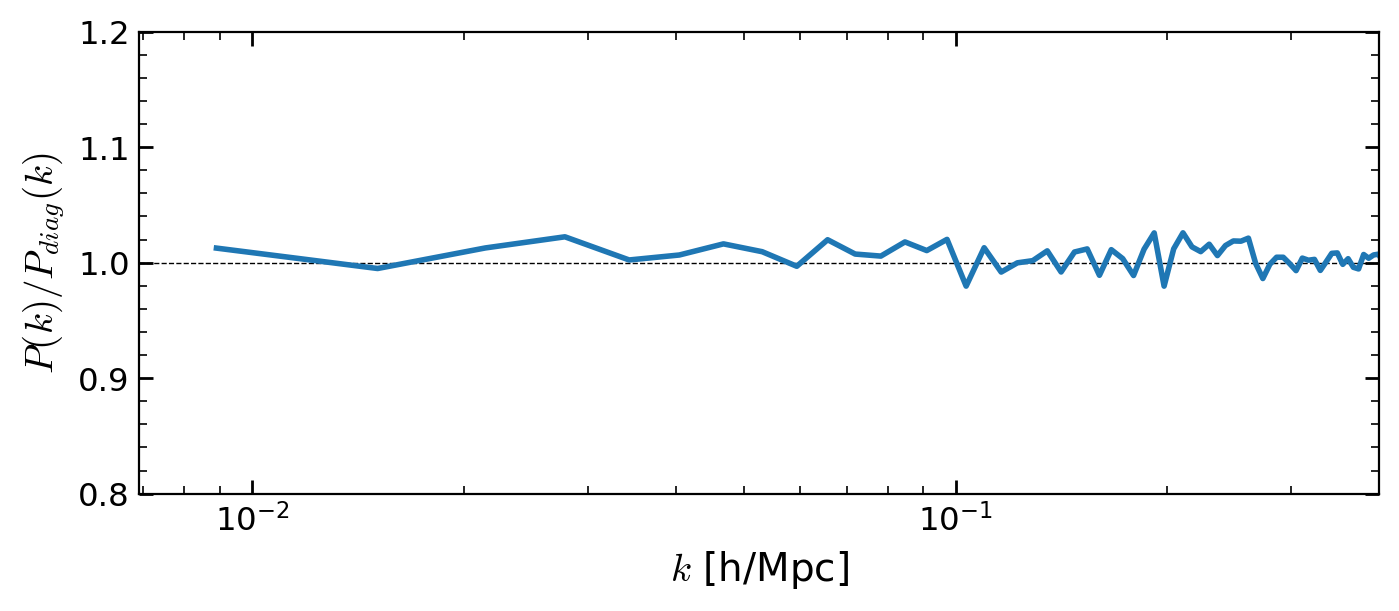

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.semilogx()
ax.axhline(1, color='k', lw=0.5, ls='--')
ax.plot(k, Pk[:, 0] / diag['Pk'][:, 0])
ax.set_xlim(None, 0.4)
ax.set_ylim(0.8, 1.2)
ax.set(xlabel=r'$k$ [h/Mpc]', ylabel=r'$P(k) / P_{diag}(k)$')

### z-space

In [7]:
pos %= L

print(len(pos))
Ncut = 100_000
mask = np.argsort(mass)[-Ncut:]
pos = pos[mask]
vel = vel[mask]
mass = mass[mask]
print(len(pos))

671684
100000


In [8]:
Lnoise = (1000/128)/np.sqrt(3)  # Set by CHARM resolution
pos += np.random.randn(*pos.shape) * Lnoise

In [9]:
from cmass.diagnostics.summ import get_mesh_resolution
N, MAS = get_mesh_resolution(L, True)
print(N, MAS)

256 TSC


In [ ]:
import redshift_space_library as RSL

z = 0.5

axis = 0
pos, vel = map(np.ascontiguousarray, (pos, vel))
RSL.pos_redshift_space(pos, vel, L, cosmo.H(z).value/cosmo.h, z, axis)

In [11]:
import MAS_library as MASL

pos = np.ascontiguousarray(pos)
delta = np.zeros((N, N, N), dtype=np.float32)
pos %= L
MASL.MA(pos, delta, BoxSize=L, MAS=MAS)
delta = delta.astype(np.float64)
delta /= np.mean(delta)
delta -= 1

In [ ]:
import Pk_library as PKL
axis = 0
threads = 1
Pk = PKL.Pk(delta.astype(np.float32), L, axis, MAS, threads, verbose=False)
k = Pk.k3D
Pk = Pk.Pk
print(k.shape, Pk.shape)

(221,) (221, 3)


[Text(0.5, 0, '$k$ [h/Mpc]'), Text(0, 0.5, '$P(k) / P_{diag}(k)$')]

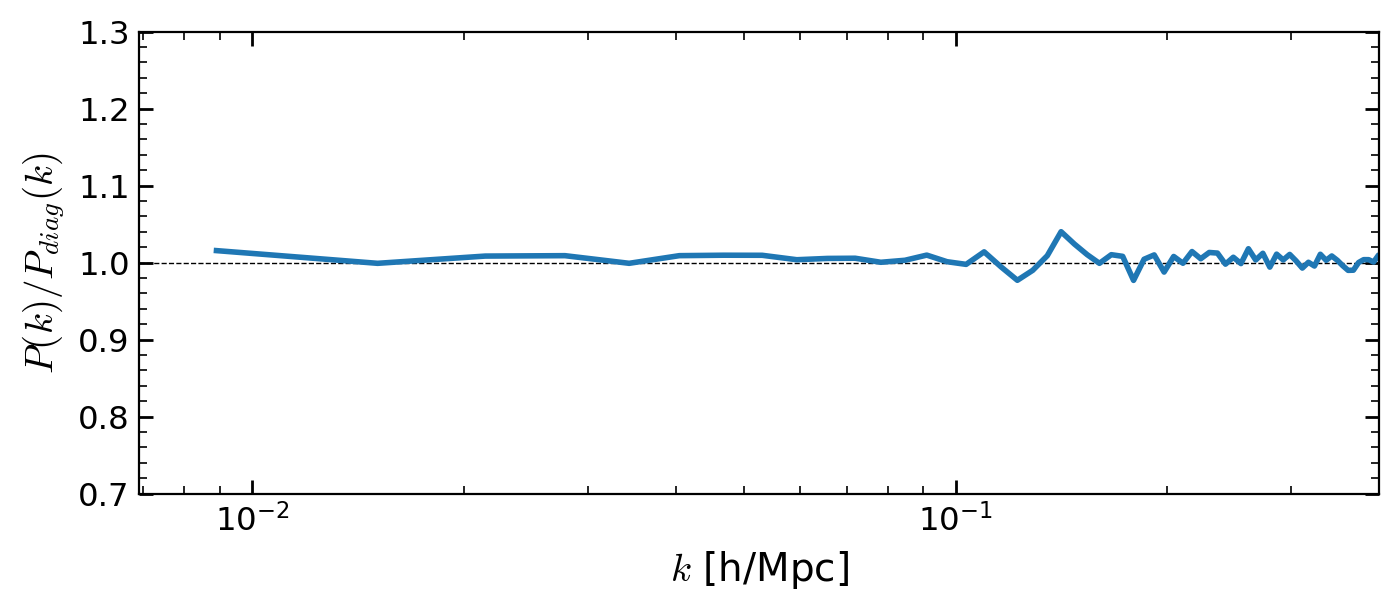

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.semilogx()
ax.axhline(1, color='k', lw=0.5, ls='--')
ax.plot(k, Pk[:, 0] / diag['zPk'][:, 0])
ax.set_xlim(None, 0.4)
ax.set_ylim(0.7, 1.3)
ax.set(xlabel=r'$k$ [h/Mpc]', ylabel=r'$P(k) / P_{diag}(k)$')

## Are we computing RSDs right? (yes)
Done in port_abacus.ipynb

## Summaries as a fn of Om, s8

In [ ]:
a = 1/(1+0.5)
a = f'{a:.6f}'
kmax = 0.4


def load_diag(file, a):
    o = {}
    with h5py.File(file, 'r') as f:
        for k, v in f[a].items():
            o[k] = np.array(v)
    return o


def get_mass(file, a):
    with h5py.File(file, 'r') as f:
        mass = np.array(f[a]['mass'])
    return mass


filename = join(abadir, '130', 'diag/halos.h5')
out = load_diag(filename, a)

100%|██████████| 6/6 [00:00<00:00, 161.69it/s]


Text(0.5, 0.98, 'Omega_m = 0.3 +/- 0.01')

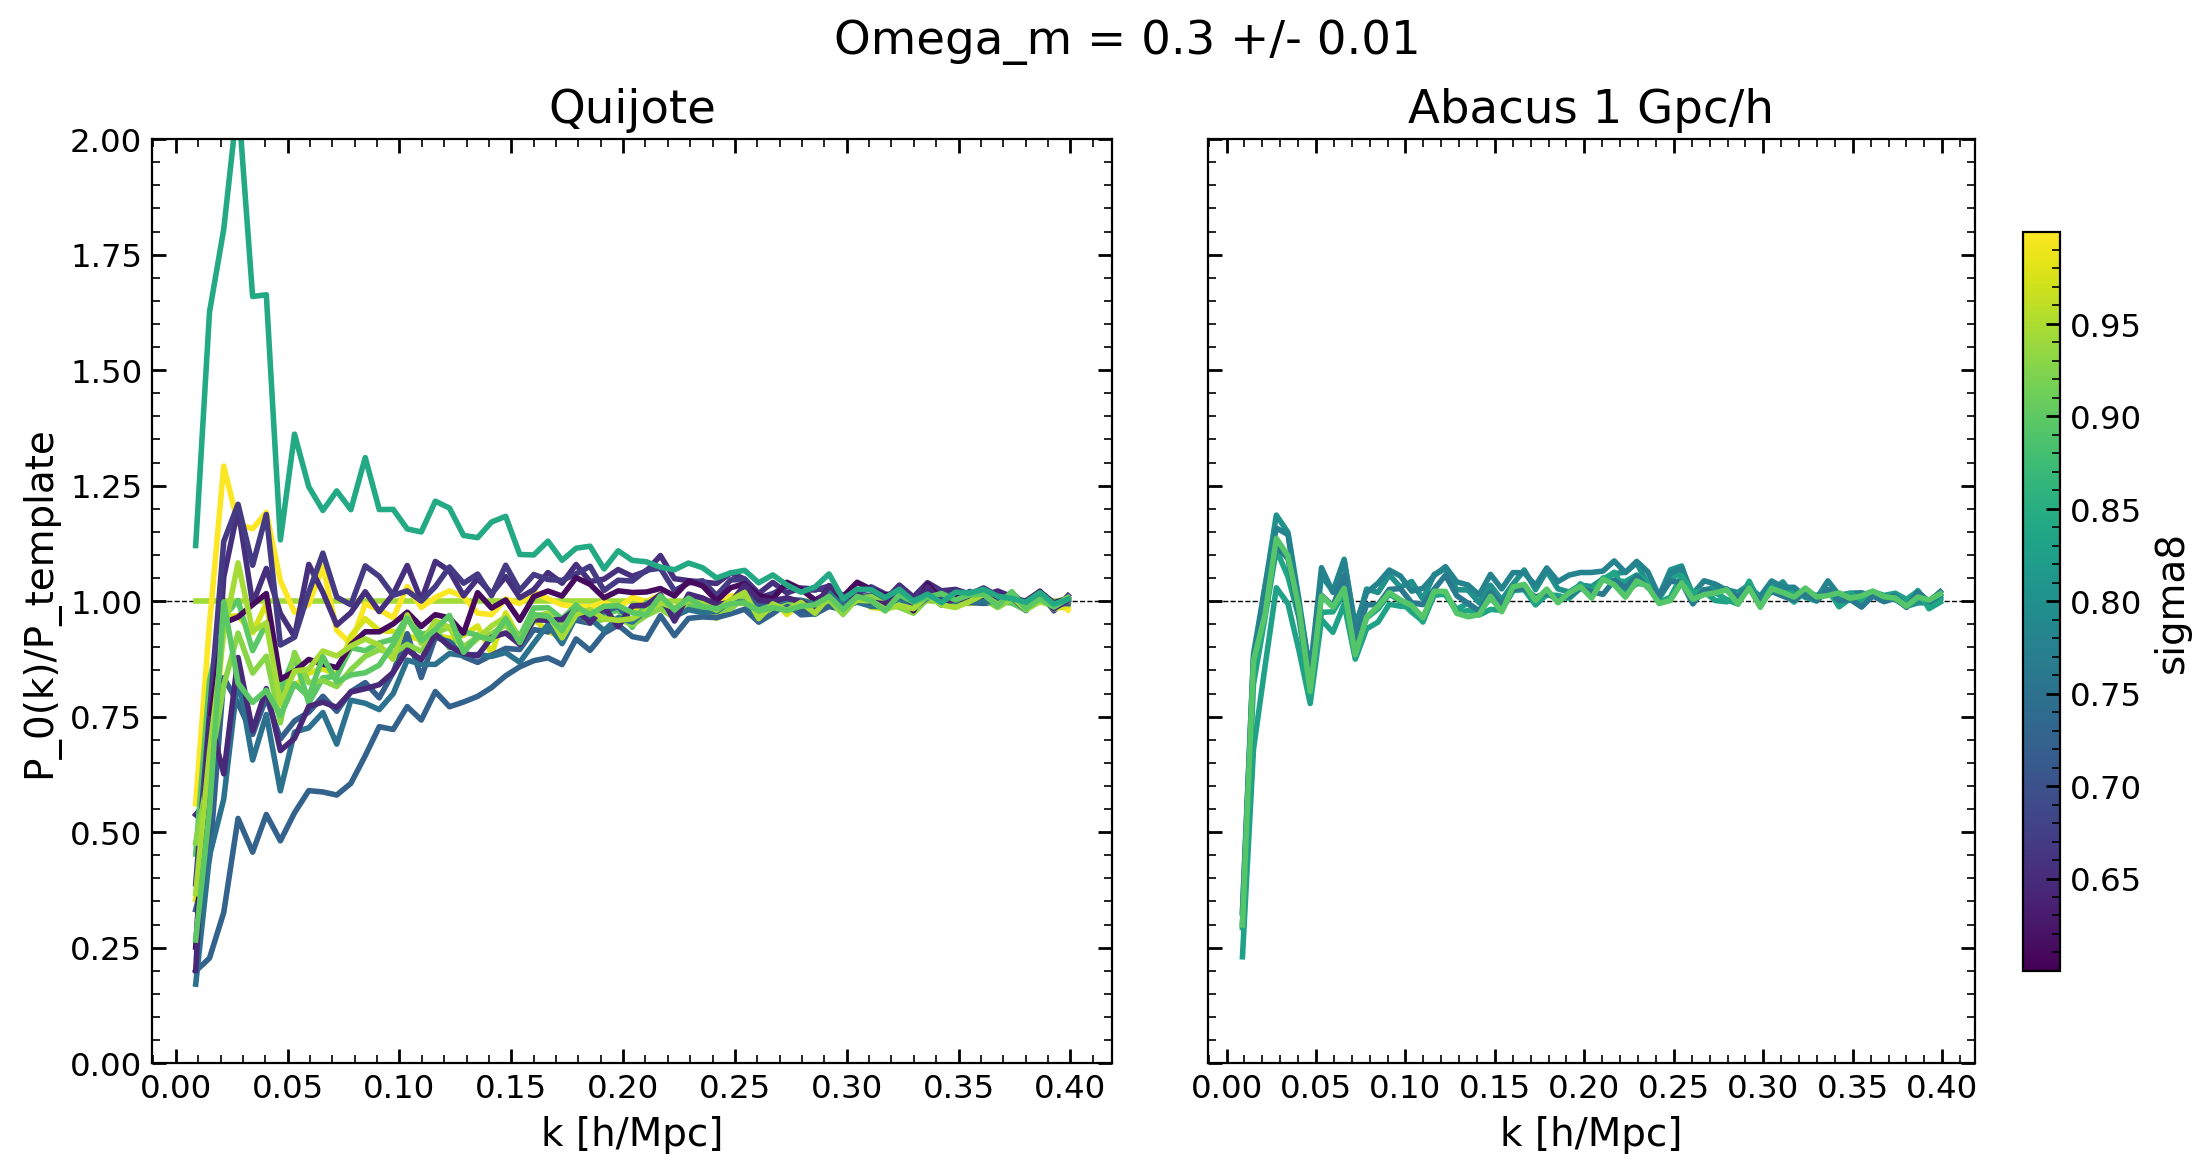

In [ ]:
col = 0
v, dv = 0.3, 0.01

ccol = 4

t = quiparams.iloc[:, col].values
quiidx = np.argwhere((t > v - dv) & (t < v + dv)).flatten()
quiidx = quiparams.index[quiidx].values
t = abaparams.iloc[:, col].values
abaidx = np.argwhere((t > v - dv) & (t < v + dv)).flatten()
abaidx = abaparams.index[abaidx].values

colormap = mpl.cm.viridis
norm = mpl.colors.Normalize(
    vmin=quiparams.loc[:, ccol].min(), vmax=quiparams.loc[:, ccol].max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=colormap)

template = load_diag(
    join(quidir, str(quiidx[0]), 'diag/halos.h5'), a)['zPk'][:, 0]


f, axs = plt.subplots(1, 2, figsize=(13, 6), sharey=True,
                      sharex=True, gridspec_kw={'wspace': 0.1})
ax = axs[0]
ax.axhline(1, color='k', lw=0.5, ls='--')
for i in tqdm(quiidx[::7]):
    file = join(quidir, str(i), 'diag/halos.h5')
    out = load_diag(file, a)
    k = out['zPk_k3D']
    pk = out['zPk'][:, 0]/template
    m = k < kmax
    k = k[m]
    pk = pk[m]
    ax.plot(k, pk, alpha=1, color=cmap.to_rgba(quiparams.loc[i, ccol]))
ax.set(xlabel='k [h/Mpc]', ylabel=r'P_0(k)/P_template')
ax.set_title('Quijote')
ax.set_ylim(0, 2)

ax = axs[1]
ax.axhline(1, color='k', lw=0.5, ls='--')
for i in tqdm(abaidx):
    file = join(abadir, str(i), 'diag/halos.h5')
    out = load_diag(file, a)
    k = out['zPk_k3D']
    pk = out['zPk'][:, 0]/template
    m = k < kmax
    k = k[m]
    pk = pk[m]
    ax.plot(k, pk, alpha=1, color=cmap.to_rgba(abaparams.loc[i, ccol]))
ax.set(xlabel='k [h/Mpc]')
ax.set_title('Abacus 1 Gpc/h')

plt.colorbar(cmap, label='sigma8', ax=ax, orientation='vertical', shrink=0.8)

f.suptitle(f'Omega_m = {v} +/- {dv}')

100%|██████████| 23/23 [00:00<00:00, 168.68it/s]


Text(0.5, 0.98, 'sigma_8 = 0.75 +/- 0.05')

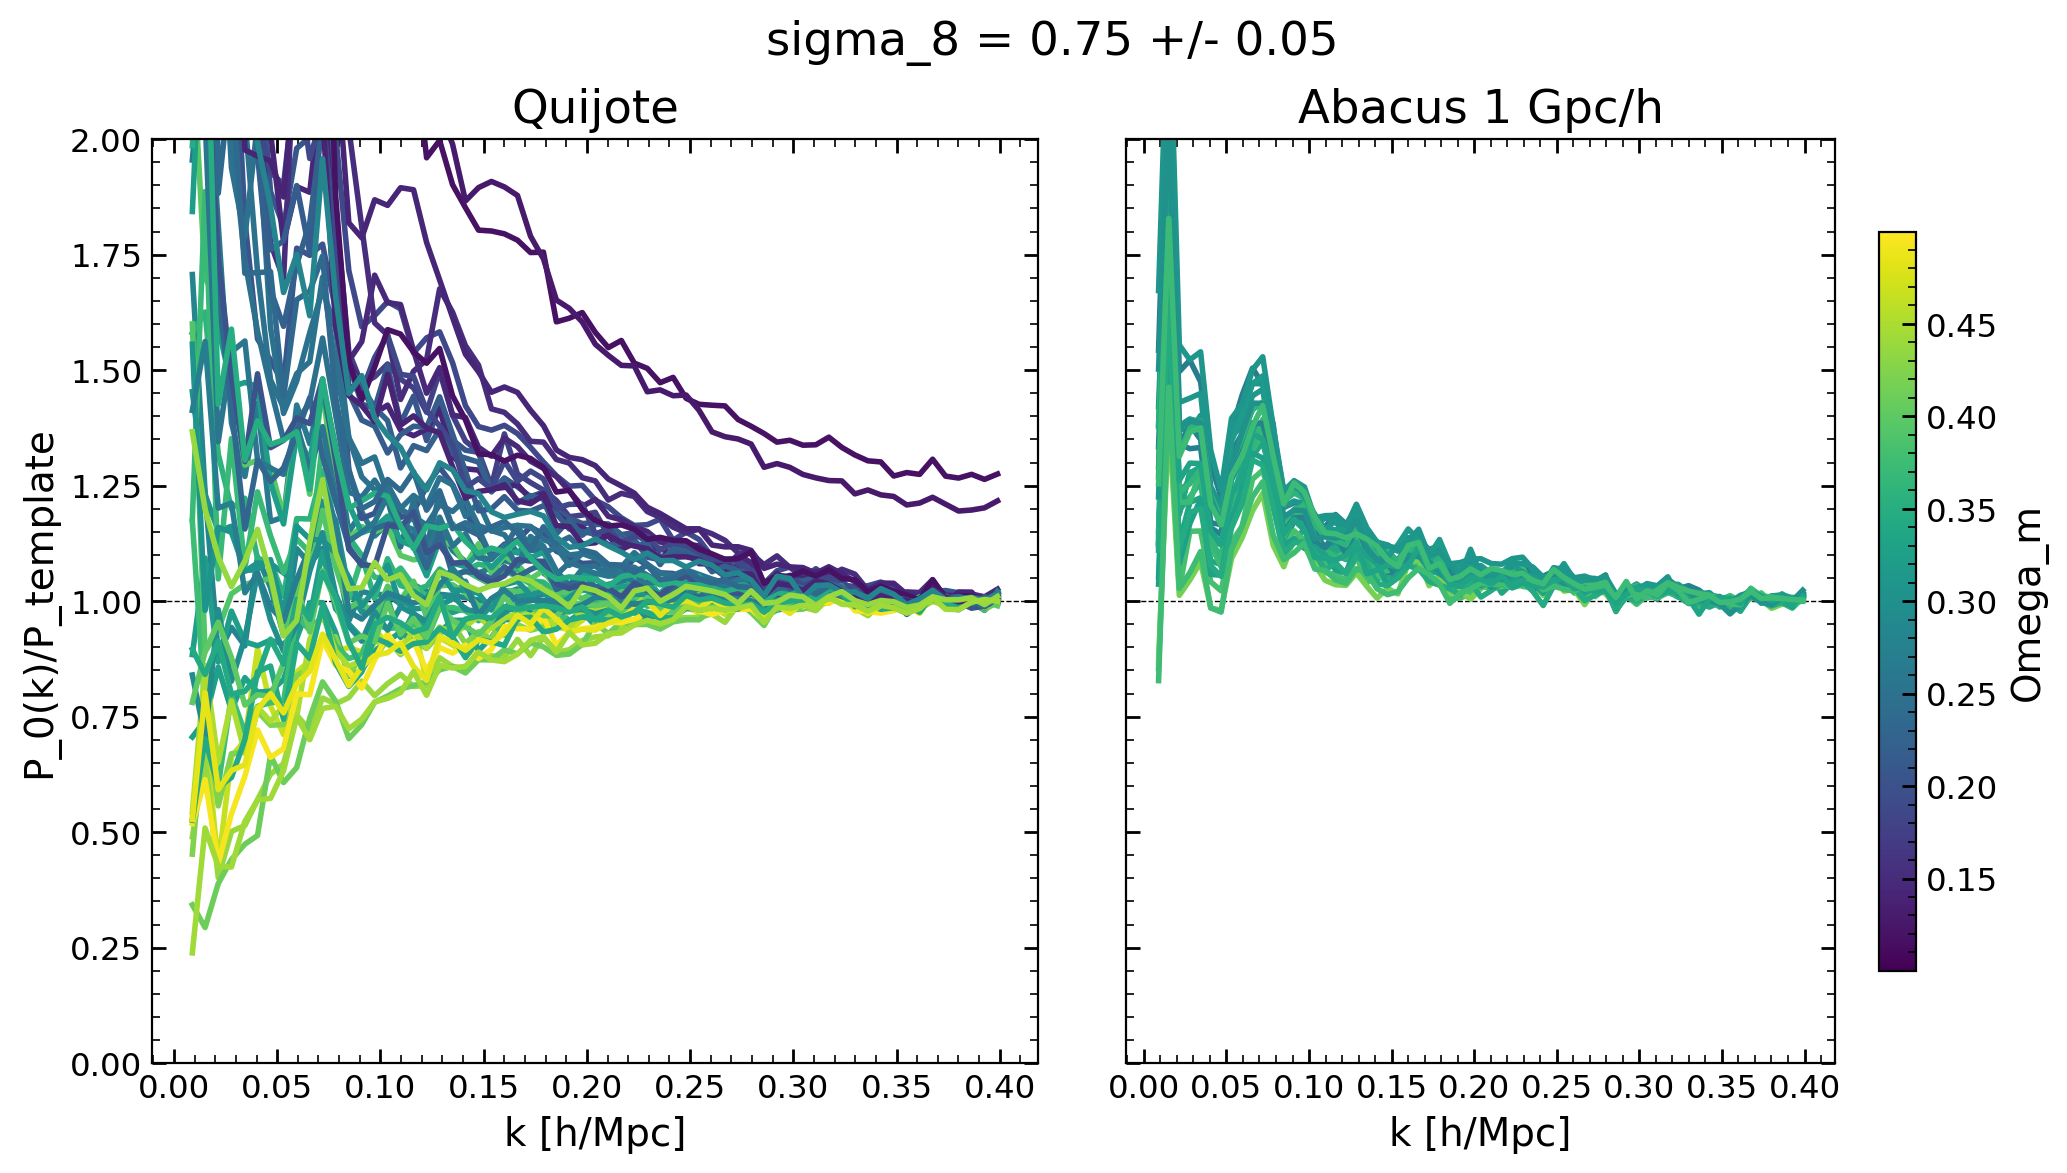

In [ ]:
col = 4
v, dv = 0.75, 0.05

ccol = 0

t = quiparams.iloc[:, col].values
quiidx = np.argwhere((t > v - dv) & (t < v + dv)).flatten()
quiidx = quiparams.index[quiidx].values
t = abaparams.iloc[:, col].values
abaidx = np.argwhere((t > v - dv) & (t < v + dv)).flatten()
abaidx = abaparams.index[abaidx].values

colormap = mpl.cm.viridis
norm = mpl.colors.Normalize(
    vmin=quiparams.loc[:, ccol].min(), vmax=quiparams.loc[:, ccol].max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=colormap)

template = load_diag(
    join(quidir, str(quiidx[-1]), 'diag/halos.h5'), a)['zPk'][:, 0]


f, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True,
                      sharex=True, gridspec_kw={'wspace': 0.1})
ax = axs[0]
ax.axhline(1, color='k', lw=0.5, ls='--')
for i in tqdm(quiidx[::10]):
    file = join(quidir, str(i), 'diag/halos.h5')
    out = load_diag(file, a)
    k = out['zPk_k3D']
    pk = out['zPk'][:, 0]/template
    m = k < kmax
    k = k[m]
    pk = pk[m]
    ax.plot(k, pk, alpha=1, color=cmap.to_rgba(quiparams.loc[i, ccol]))
ax.set(xlabel='k [h/Mpc]', ylabel=r'P_0(k)/P_template')
ax.set_title('Quijote')
ax.set_ylim(0, 2)

ax = axs[1]
ax.axhline(1, color='k', lw=0.5, ls='--')
for i in tqdm(abaidx):
    file = join(abadir, str(i), 'diag/halos.h5')
    out = load_diag(file, a)
    k = out['zPk_k3D']
    pk = out['zPk'][:, 0]/template
    m = k < kmax
    k = k[m]
    pk = pk[m]
    ax.plot(k, pk, alpha=1, color=cmap.to_rgba(abaparams.loc[i, ccol]))
ax.set(xlabel='k [h/Mpc]')
ax.set_title('Abacus 1 Gpc/h')

plt.colorbar(cmap, label='Omega_m', ax=ax, orientation='vertical', shrink=0.8)

f.suptitle(f'sigma_8 = {v} +/- {dv}')

100%|██████████| 6/6 [00:03<00:00,  1.95it/s]


Text(0.5, 0.98, 'Omega_m = 0.3 +/- 0.01')

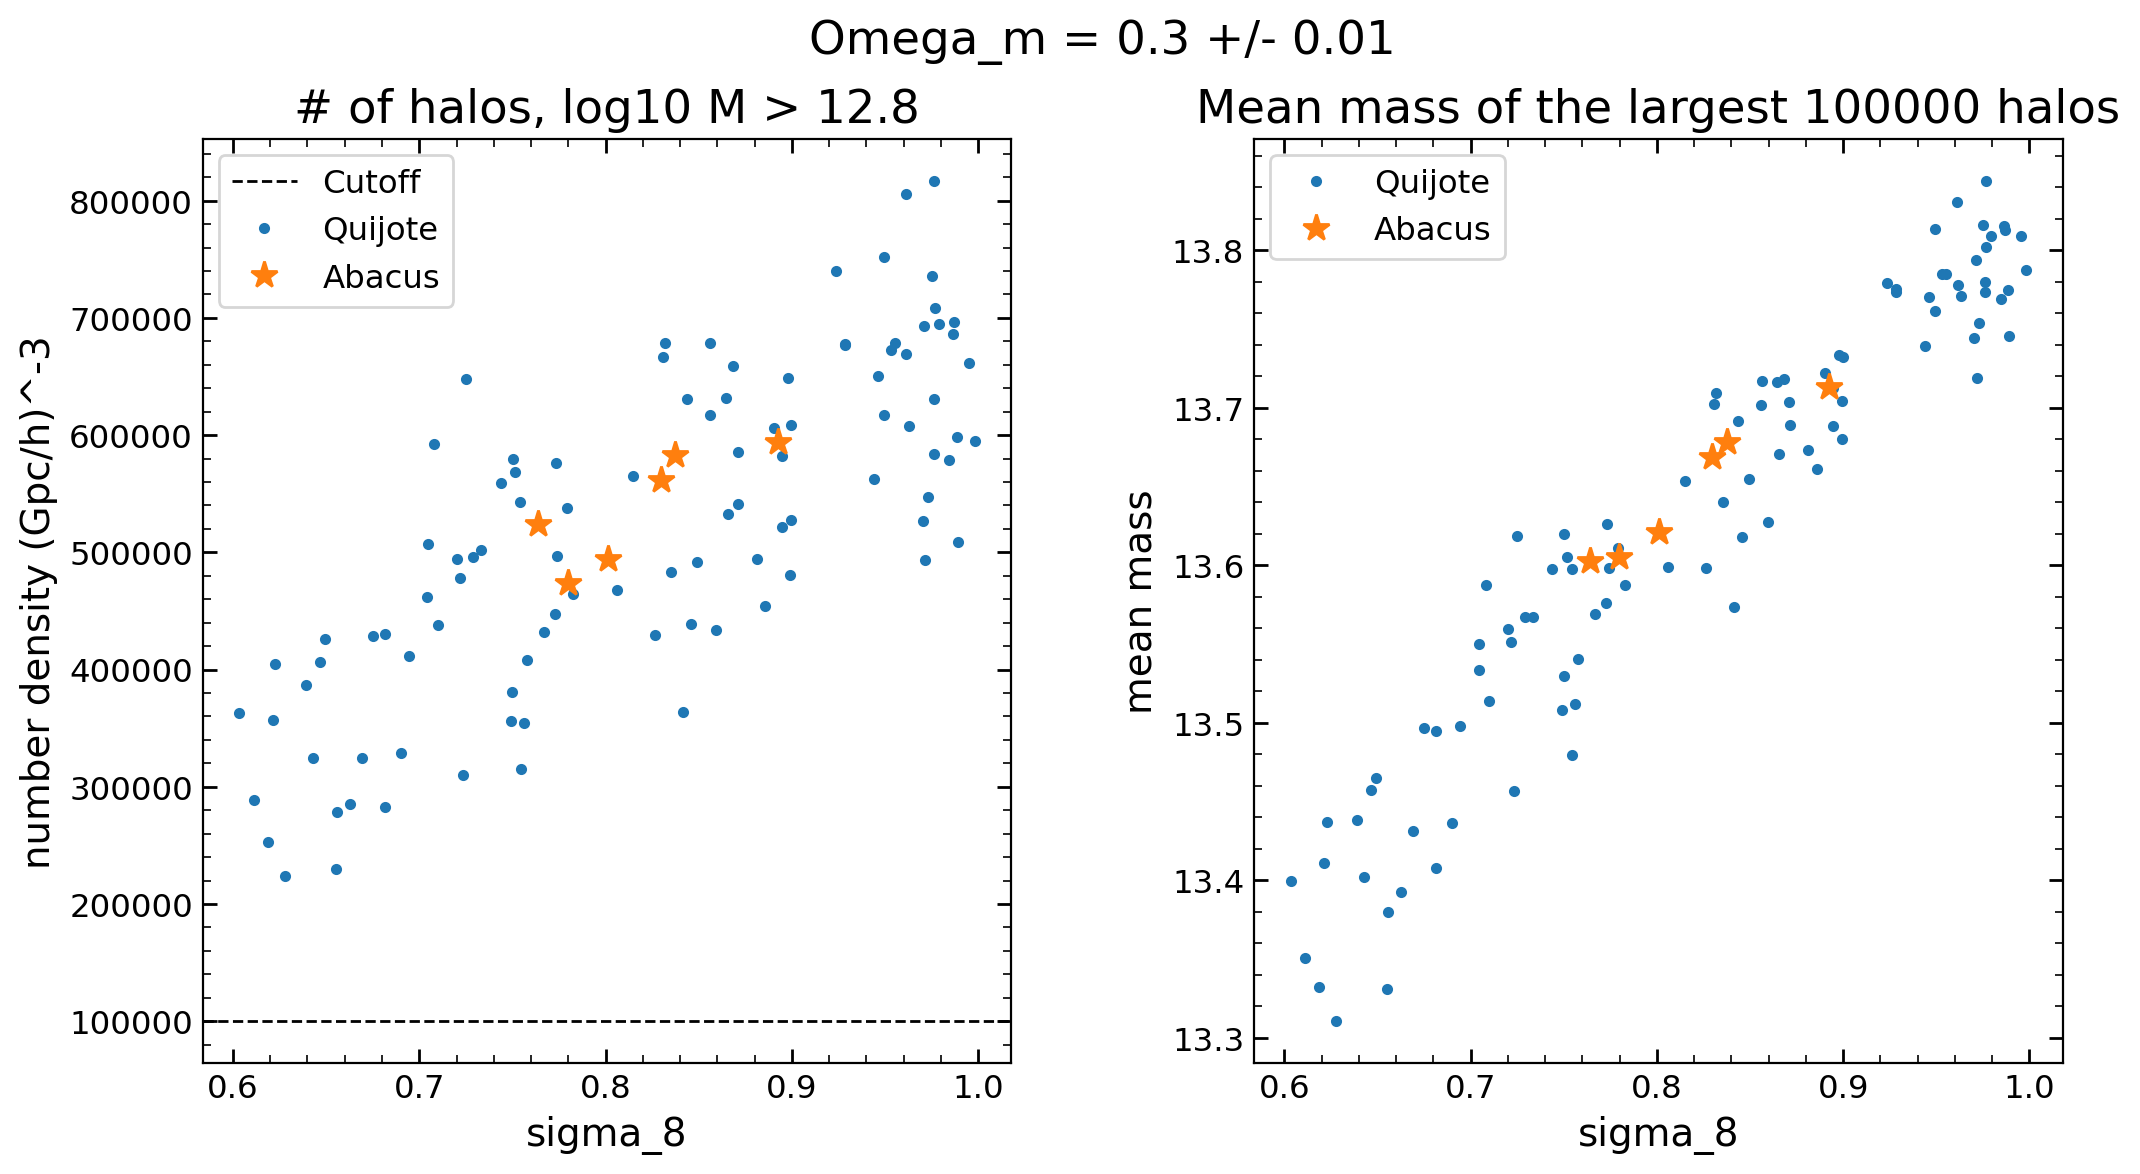

In [ ]:
col = 0
v, dv = 0.3, 0.01

ccol = 4

cutoff = int(1e-4*(1e3)**3)

t = quiparams.iloc[:, col].values
quiidx = np.argwhere((t > v - dv) & (t < v + dv)).flatten()
quiidx = quiparams.index[quiidx].values
t = abaparams.iloc[:, col].values
abaidx = np.argwhere((t > v - dv) & (t < v + dv)).flatten()
abaidx = abaparams.index[abaidx].values

f, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False,
                      sharex=True, gridspec_kw={'wspace': 0.3})
ax = axs[0]
ax.axhline(cutoff, color='k', lw=1, ls='--', label='Cutoff')
for i in tqdm(quiidx):
    file = join(quidir, str(i), 'halos.h5')
    masses = get_mass(file, a)
    x = quiparams.loc[i, ccol]
    y = np.sum(masses > 12.8)
    ax.plot(x, y, 'o', markersize=3, c='C0',
            label='Quijote' if i == quiidx[0] else "")
for i in tqdm(abaidx):
    file = join(abadir, str(i), 'halos.h5')
    masses = get_mass(file, a)
    x = abaparams.loc[i, ccol]
    y = np.sum(masses > 12.8)
    ax.plot(x, y, '*', markersize=10, c='C1',
            label='Abacus' if i == abaidx[0] else "")
ax.legend()
ax.set(xlabel='sigma_8', ylabel='number density (Gpc/h)^-3')
ax.set_title('# of halos, log10 M > 12.8')


ax = axs[1]
for i in tqdm(quiidx):
    file = join(quidir, str(i), 'halos.h5')
    masses = get_mass(file, a)
    x = quiparams.loc[i, ccol]
    y = np.mean(sorted(masses)[-cutoff:])
    ax.plot(x, y, 'o', markersize=3, c='C0',
            label='Quijote' if i == quiidx[0] else "")
for i in tqdm(abaidx):
    file = join(abadir, str(i), 'halos.h5')
    masses = get_mass(file, a)
    x = abaparams.loc[i, ccol]
    y = np.mean(sorted(masses)[-cutoff:])
    ax.plot(x, y, '*', markersize=10, c='C1',
            label='Abacus' if i == abaidx[0] else "")
ax.legend()
ax.set(xlabel='sigma_8', ylabel='mean mass')
ax.set_title(f'Mean mass of the largest {cutoff} halos')

f.suptitle(f'Omega_m = {v} +/- {dv}')

100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Text(0.5, 0.98, 'sigma_8 = 0.75 +/- 0.02')

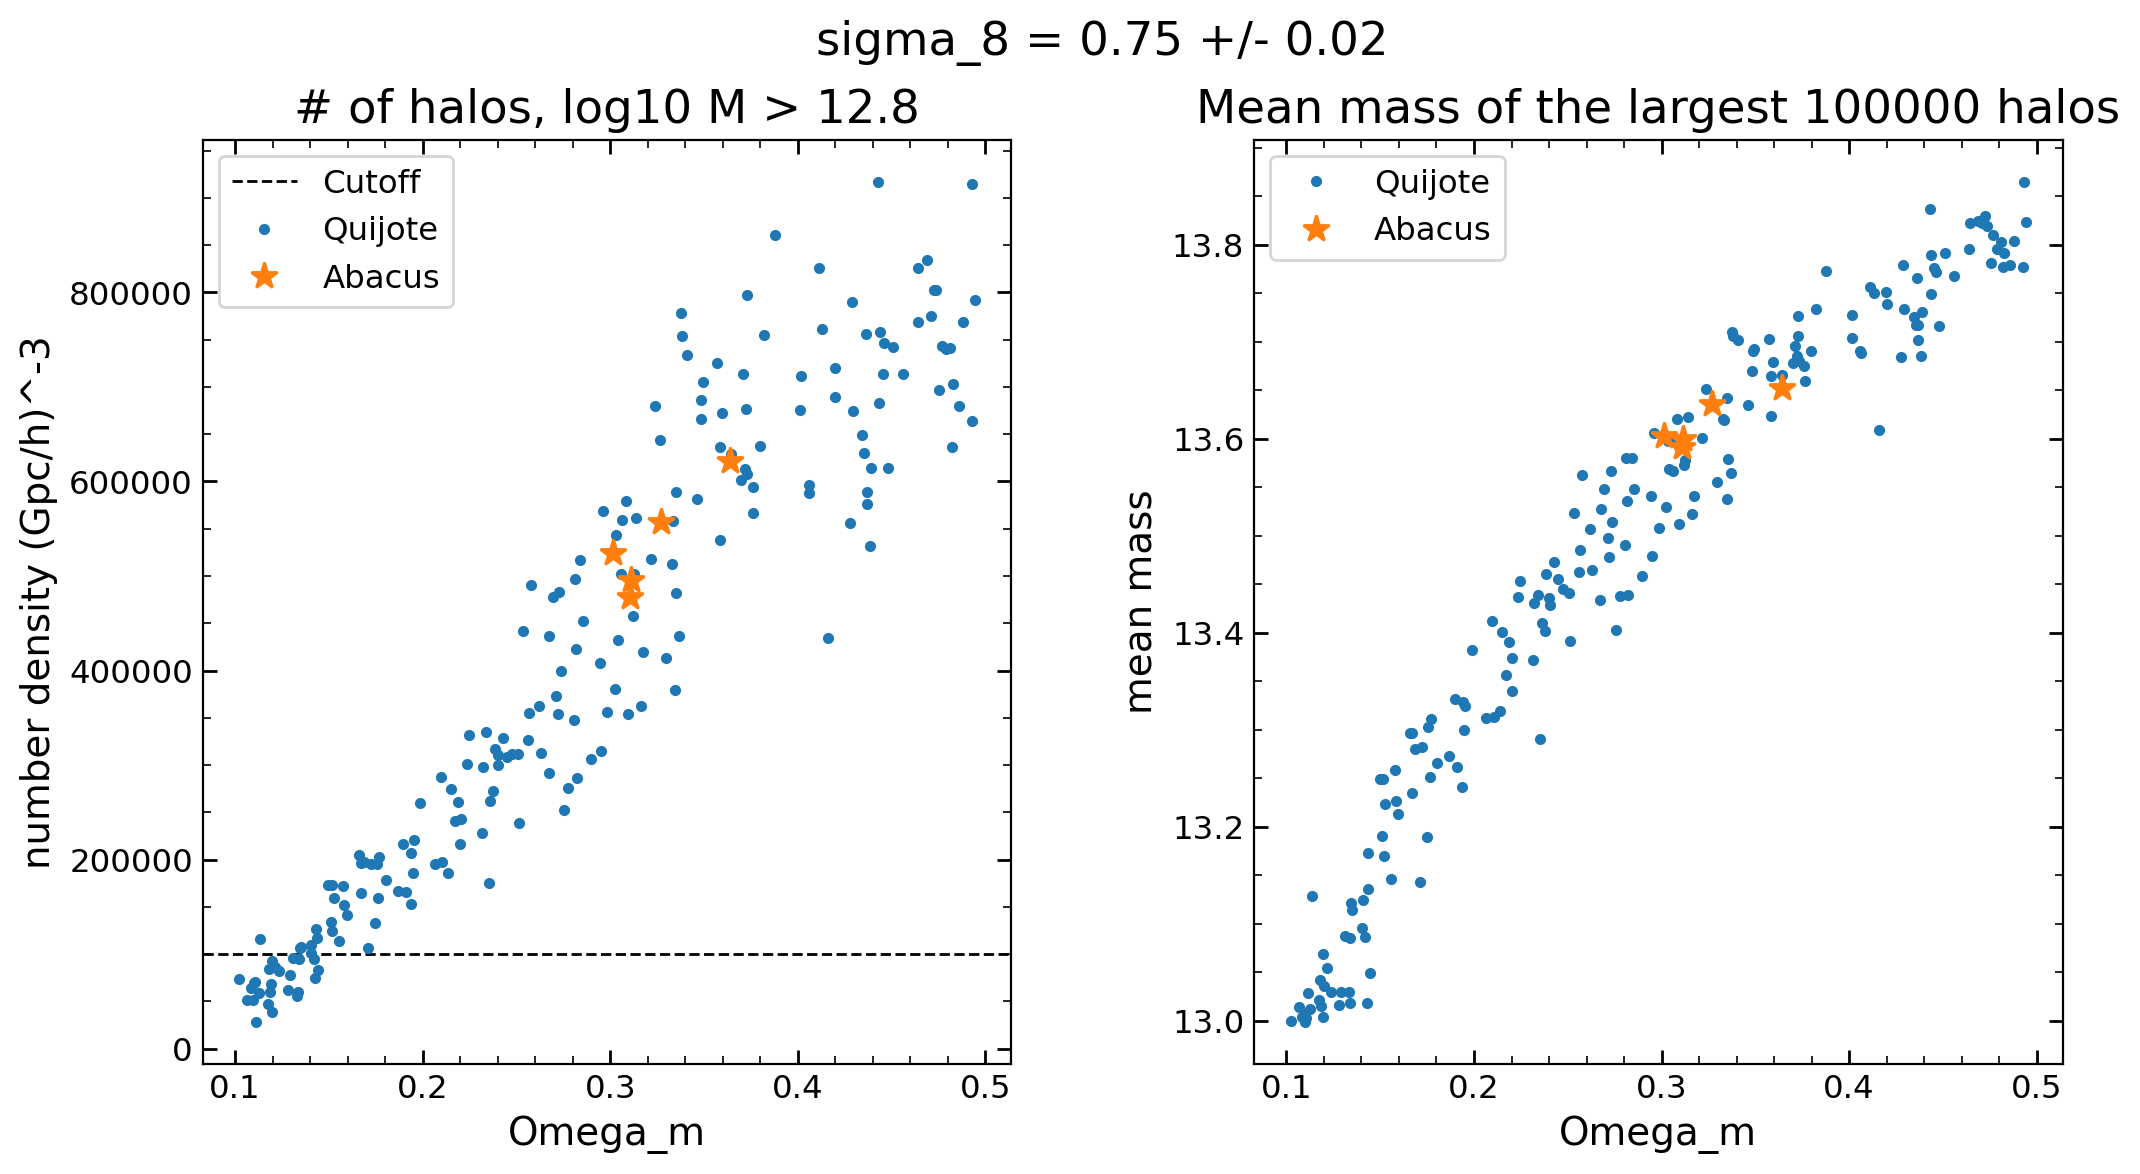

In [ ]:
col = 4
v, dv = 0.75, 0.02

ccol = 0

cutoff = int(1e-4*(1e3)**3)

t = quiparams.iloc[:, col].values
quiidx = np.argwhere((t > v - dv) & (t < v + dv)).flatten()
quiidx = quiparams.index[quiidx].values
t = abaparams.iloc[:, col].values
abaidx = np.argwhere((t > v - dv) & (t < v + dv)).flatten()
abaidx = abaparams.index[abaidx].values

f, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False,
                      sharex=True, gridspec_kw={'wspace': 0.3})
ax = axs[0]
ax.axhline(cutoff, color='k', lw=1, ls='--', label='Cutoff')
for i in tqdm(quiidx):
    file = join(quidir, str(i), 'halos.h5')
    masses = get_mass(file, a)
    x = quiparams.loc[i, ccol]
    y = np.sum(masses > 12.8)
    ax.plot(x, y, 'o', markersize=3, c='C0',
            label='Quijote' if i == quiidx[0] else "")
for i in tqdm(abaidx):
    file = join(abadir, str(i), 'halos.h5')
    masses = get_mass(file, a)
    x = abaparams.loc[i, ccol]
    y = np.sum(masses > 12.8)
    ax.plot(x, y, '*', markersize=10, c='C1',
            label='Abacus' if i == abaidx[0] else "")
ax.legend()
ax.set(xlabel='Omega_m', ylabel='number density (Gpc/h)^-3')
ax.set_title('# of halos, log10 M > 12.8')


ax = axs[1]
for i in tqdm(quiidx):
    file = join(quidir, str(i), 'halos.h5')
    masses = get_mass(file, a)
    x = quiparams.loc[i, ccol]
    y = np.mean(sorted(masses)[-cutoff:])
    ax.plot(x, y, 'o', markersize=3, c='C0',
            label='Quijote' if i == quiidx[0] else "")
for i in tqdm(abaidx):
    file = join(abadir, str(i), 'halos.h5')
    masses = get_mass(file, a)
    x = abaparams.loc[i, ccol]
    y = np.mean(sorted(masses)[-cutoff:])
    ax.plot(x, y, '*', markersize=10, c='C1',
            label='Abacus' if i == abaidx[0] else "")
ax.legend()
ax.set(xlabel='Omega_m', ylabel='mean mass')
ax.set_title(f'Mean mass of the largest {cutoff} halos')

f.suptitle(f'sigma_8 = {v} +/- {dv}')

## Find what's different between close cosmologies

In [3]:
abaidx = 136
abaoms8 = abaparams.loc[abaidx, [0, 4]].values
quios8 = quiparams.iloc[:, [0, 4]].values

quiidx = np.argmin(np.sum((quios8 - abaoms8)**2, axis=1))

quios8 = quiparams.iloc[quiidx, [0, 4]].values
print(quiidx, quios8)
print(abaidx, abaoms8)

678 [0.3201 0.8871]
136 [0.31949  0.882475]


In [4]:
def get_all(file, a):
    with h5py.File(file, 'r') as f:
        pos, vel, mass = f[a]['pos'][()], f[a]['vel'][()], f[a]['mass'][()]
    return pos, vel, mass


a = 1/(1+0.5)
a = f'{a:.6f}'
apos, avel, amass = get_all(join(abadir, str(abaidx), 'halos.h5'), a)
qpos, qvel, qmass = get_all(join(quidir, str(quiidx), 'halos.h5'), a)

print('Abacus in box:', np.all((0 <= apos) & (apos <= 1000)))
print('Quijote in box:', np.all((0 <= qpos) & (qpos <= 1000)))

Abacus in box: True
Quijote in box: True


Text(0.5, 1.0, 'Quijote')

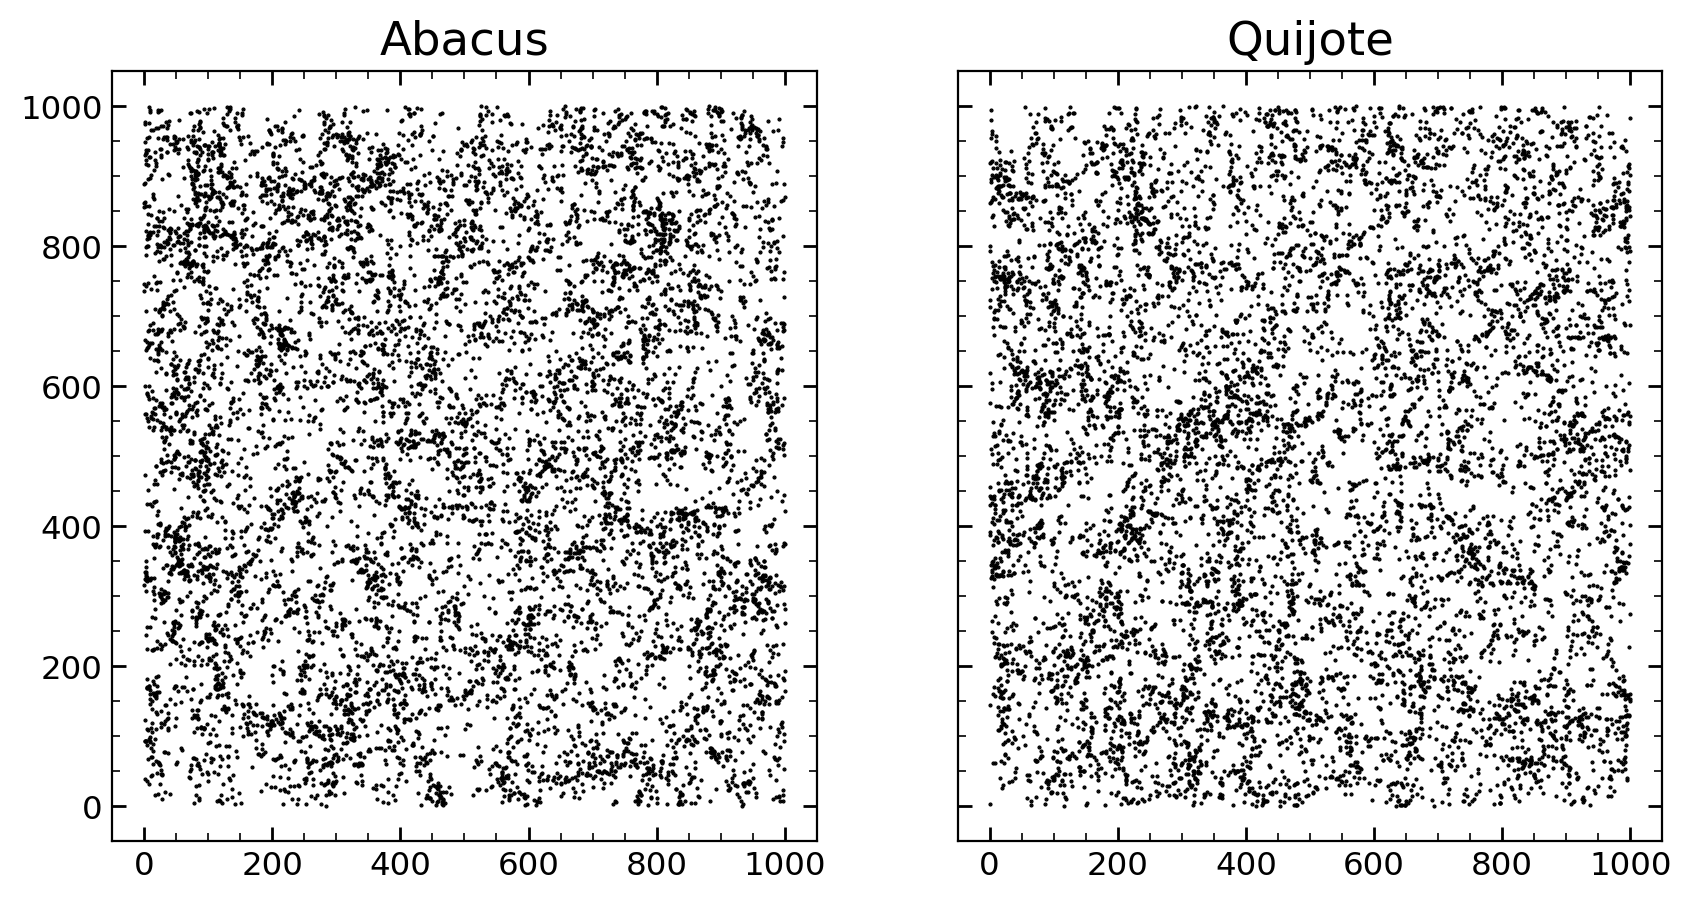

In [5]:
f, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

Nbin = 100_000
aidx = np.argsort(amass)
cidx = np.argsort(qmass)

x = apos[aidx[-Nbin:]]
y = qpos[cidx[-Nbin:]]

mask = x[:, 2] < 100
x = x[mask]
mask = y[:, 2] < 100
y = y[mask]

ax = axs[0]
ax.plot(x[:, 0], x[:, 1], 'k.', markersize=1, alpha=1)
ax.set_title('Abacus')

ax = axs[1]
ax.plot(y[:, 0], y[:, 1], 'k.', markersize=1, alpha=1)
ax.set_title('Quijote')

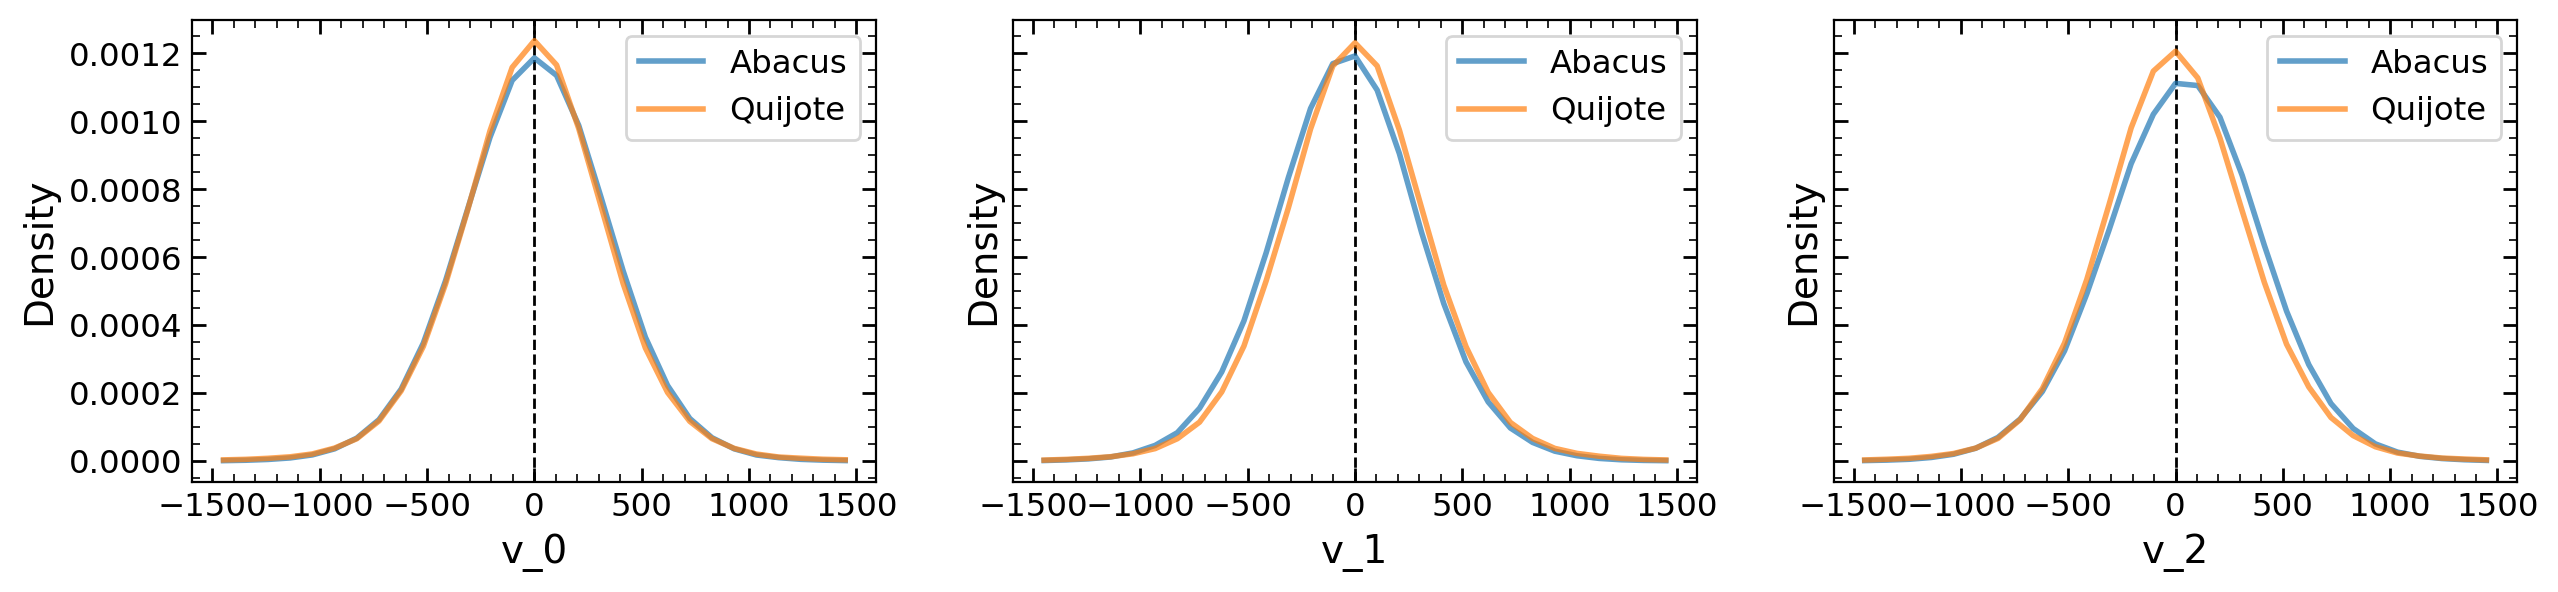

In [6]:
f, axs = plt.subplots(1, 3, figsize=(15, 3), sharey=True, sharex=True)

t = 1  # 0.8
be = np.linspace(-1500, 1500, 30)
bc = 0.5 * (be[:-1] + be[1:])

for i in range(3):
    ax = axs[i]
    ax.axvline(0, color='k', lw=1, ls='--')
    h, _ = np.histogram(avel[:, i]*t, bins=be, density=True)
    ax.plot(bc, h, label='Abacus', color='C0', alpha=0.7)
    h, _ = np.histogram(qvel[:, i], bins=be, density=True)
    ax.plot(bc, h, label='Quijote', color='C1', alpha=0.7)
    ax.legend()
    ax.set_xlabel(f'v_{i}')
    ax.set_ylabel('Density')

[Text(0.5, 0, '$\\log_{10} M_{\\rm halo}^{\\rm Abacus}$'),
 Text(0, 0.5, '$\\log_{10} M_{\\rm halo}^{\\rm FastPM}$')]

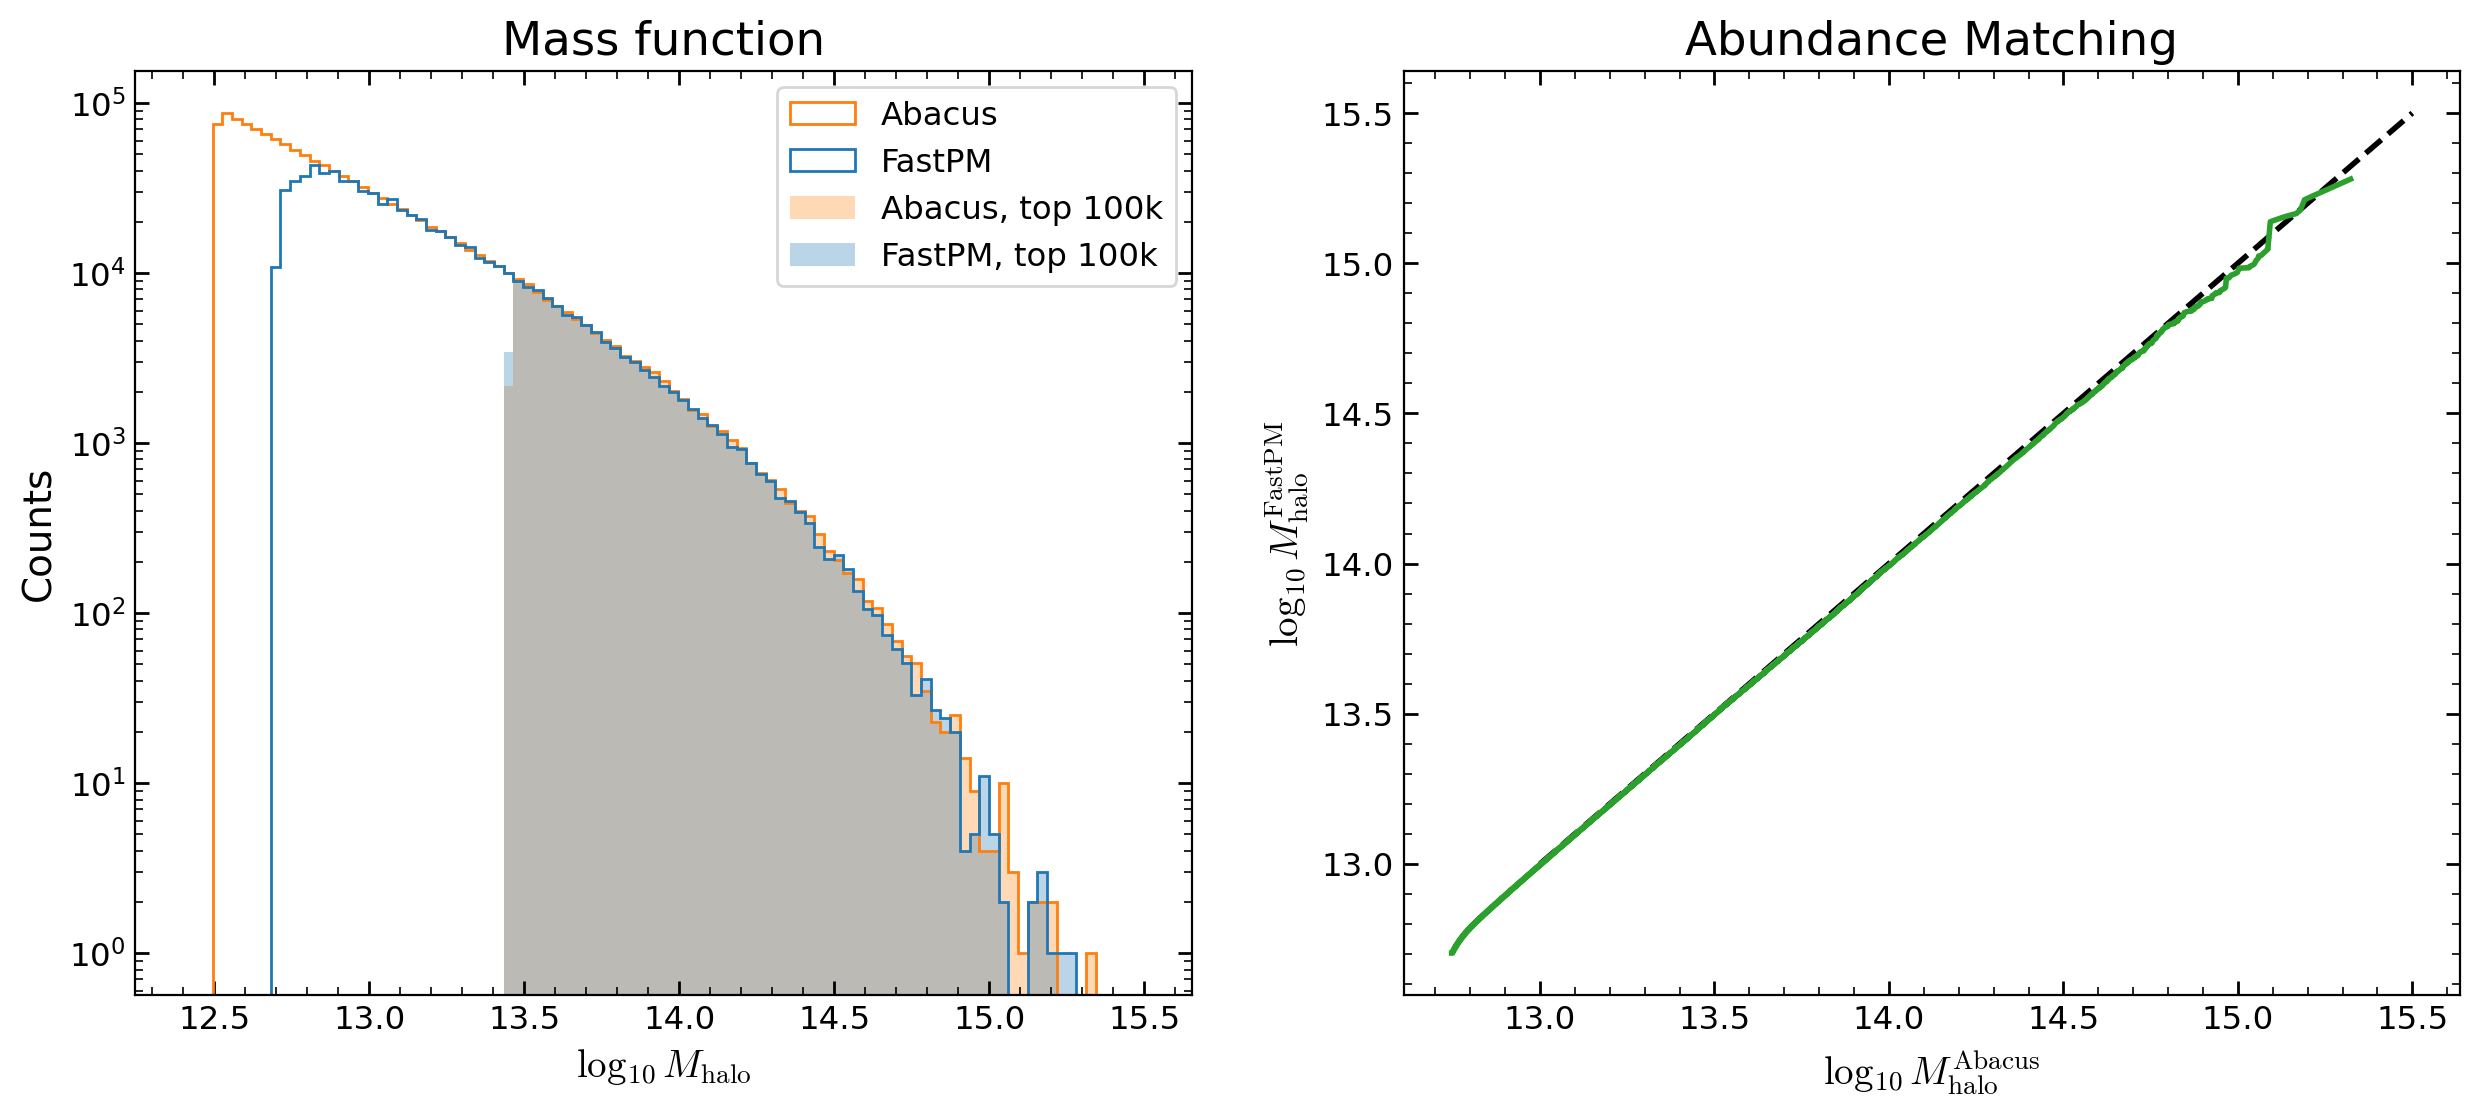

In [7]:
f, axs = plt.subplots(1, 2, figsize=(15, 6))

ax = axs[0]
ax.semilogy()
mbins = np.linspace(12.4, 15.5, 100)
ax.hist(amass, bins=mbins, histtype='step', color='C1', label='Abacus', lw=2)
ax.hist(qmass, bins=mbins, histtype='step', color='C0', label='FastPM', lw=2)
ax.hist(sorted(amass)[-int(1e5):], bins=mbins, histtype='bar',
        color='C1', label='Abacus, top 100k', alpha=0.3)
ax.hist(sorted(qmass)[-int(1e5):], bins=mbins, histtype='bar',
        color='C0', label='FastPM, top 100k', alpha=0.3)
ax.legend()
ax.set(xlabel=r'$\log_{10} M_{\rm halo}$', ylabel='Counts')
ax.set_title('Mass function')

ax = axs[1]
x = sorted(amass)
y = sorted(qmass)
N = min(len(x), len(y))
ax.plot([13, 15.5], [13, 15.5], 'k--')
ax.plot(x[-N:], y[-N:], '-', c='C2', markersize=0.1)
ax.set_title('Abundance Matching')
ax.set(xlabel=r'$\log_{10} M_{\rm halo}^{\rm Abacus}$',
       ylabel=r'$\log_{10} M_{\rm halo}^{\rm FastPM}$')

In [8]:
a = 1/(1+0.5)
a = f'{a:.6f}'
kmax = 0.4


def load_diag(file, a):
    o = {}
    with h5py.File(file, 'r') as f:
        for k, v in f[a].items():
            o[k] = np.array(v)
    return o


filename = join(abadir, str(abaidx), 'diag/halos.h5')
adiag = load_diag(filename, a)

filename = join(quidir, str(quiidx), 'diag/halos.h5')
qdiag = load_diag(filename, a)

print(adiag.keys())

dict_keys(['Bk', 'Bk_k123', 'Pk', 'Pk_k3D', 'Qk', 'bPk', 'bPk_k3D', 'mass_bins', 'mass_hist', 'zBk', 'zBk_k123', 'zPk', 'zPk_k3D', 'zQk', 'zbPk', 'zbPk_k3D'])


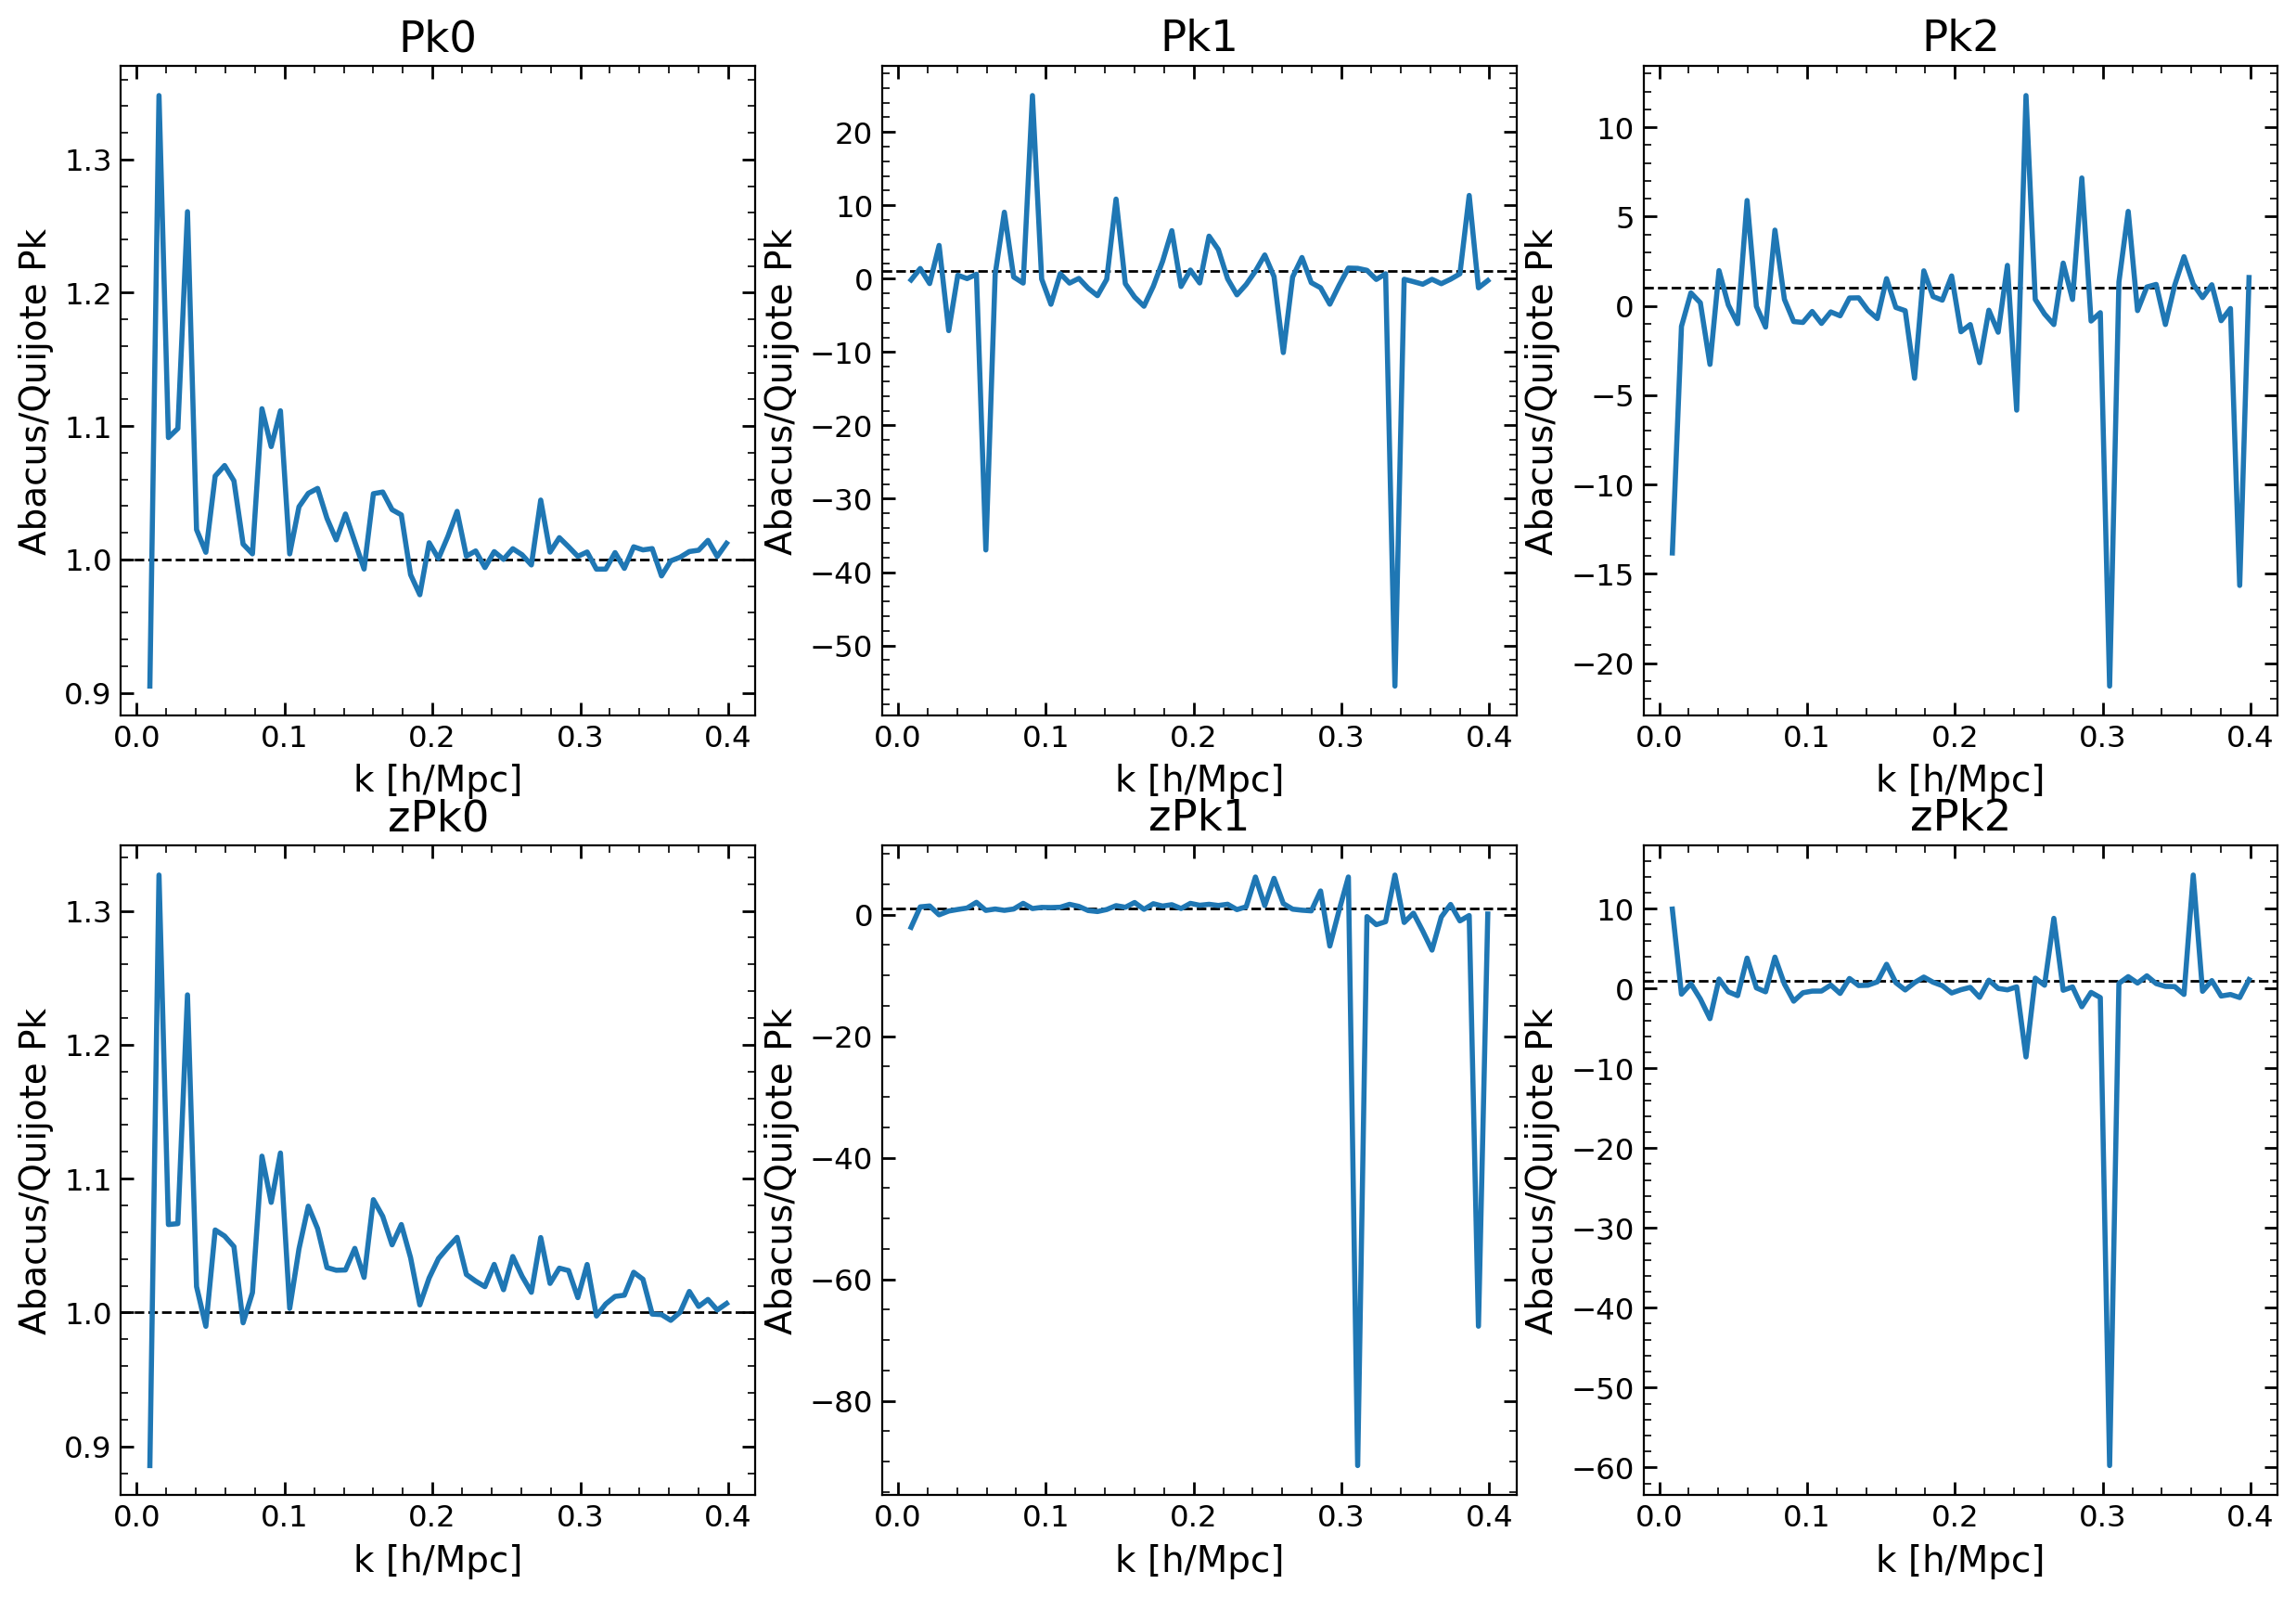

In [9]:
f, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(3):
    ax = axs[0, i]
    ax.axhline(1, color='k', lw=1, ls='--')
    k = adiag['Pk_k3D']
    pk = adiag['Pk'][:, i]/qdiag['Pk'][:, i]
    m = k < kmax
    k = k[m]
    pk = pk[m]
    ax.plot(k, pk, alpha=1, color='C0')
    ax.set_title(f'Pk{i}')
    ax.set(xlabel='k [h/Mpc]', ylabel=r'Abacus/Quijote Pk')

for i in range(3):
    ax = axs[1, i]
    ax.axhline(1, color='k', lw=1, ls='--')
    k = adiag['zPk_k3D']
    pk = adiag['zPk'][:, i]/qdiag['zPk'][:, i]
    m = k < kmax
    k = k[m]
    pk = pk[m]
    ax.plot(k, pk, alpha=1, color='C0')
    ax.set_title(f'zPk{i}')
    ax.set(xlabel='k [h/Mpc]', ylabel=r'Abacus/Quijote Pk')

## Is it a scale problem?

In [ ]:

filename = join('/anvil/scratch/x-mho1/cmass-ili/quijote3gpch/nbody/L3000-N384',
                str(2000), 'diag/halos.h5')
q3diag = load_diag(filename, a)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/anvil/scratch/x-mho1/cmass-ili/quijotelike/fastpm/L1000-N128/2000/diag/halos.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [86]:
quidir

'/anvil/scratch/x-mho1/cmass-ili/quijote/nbody/L1000-N128'

## Scratch

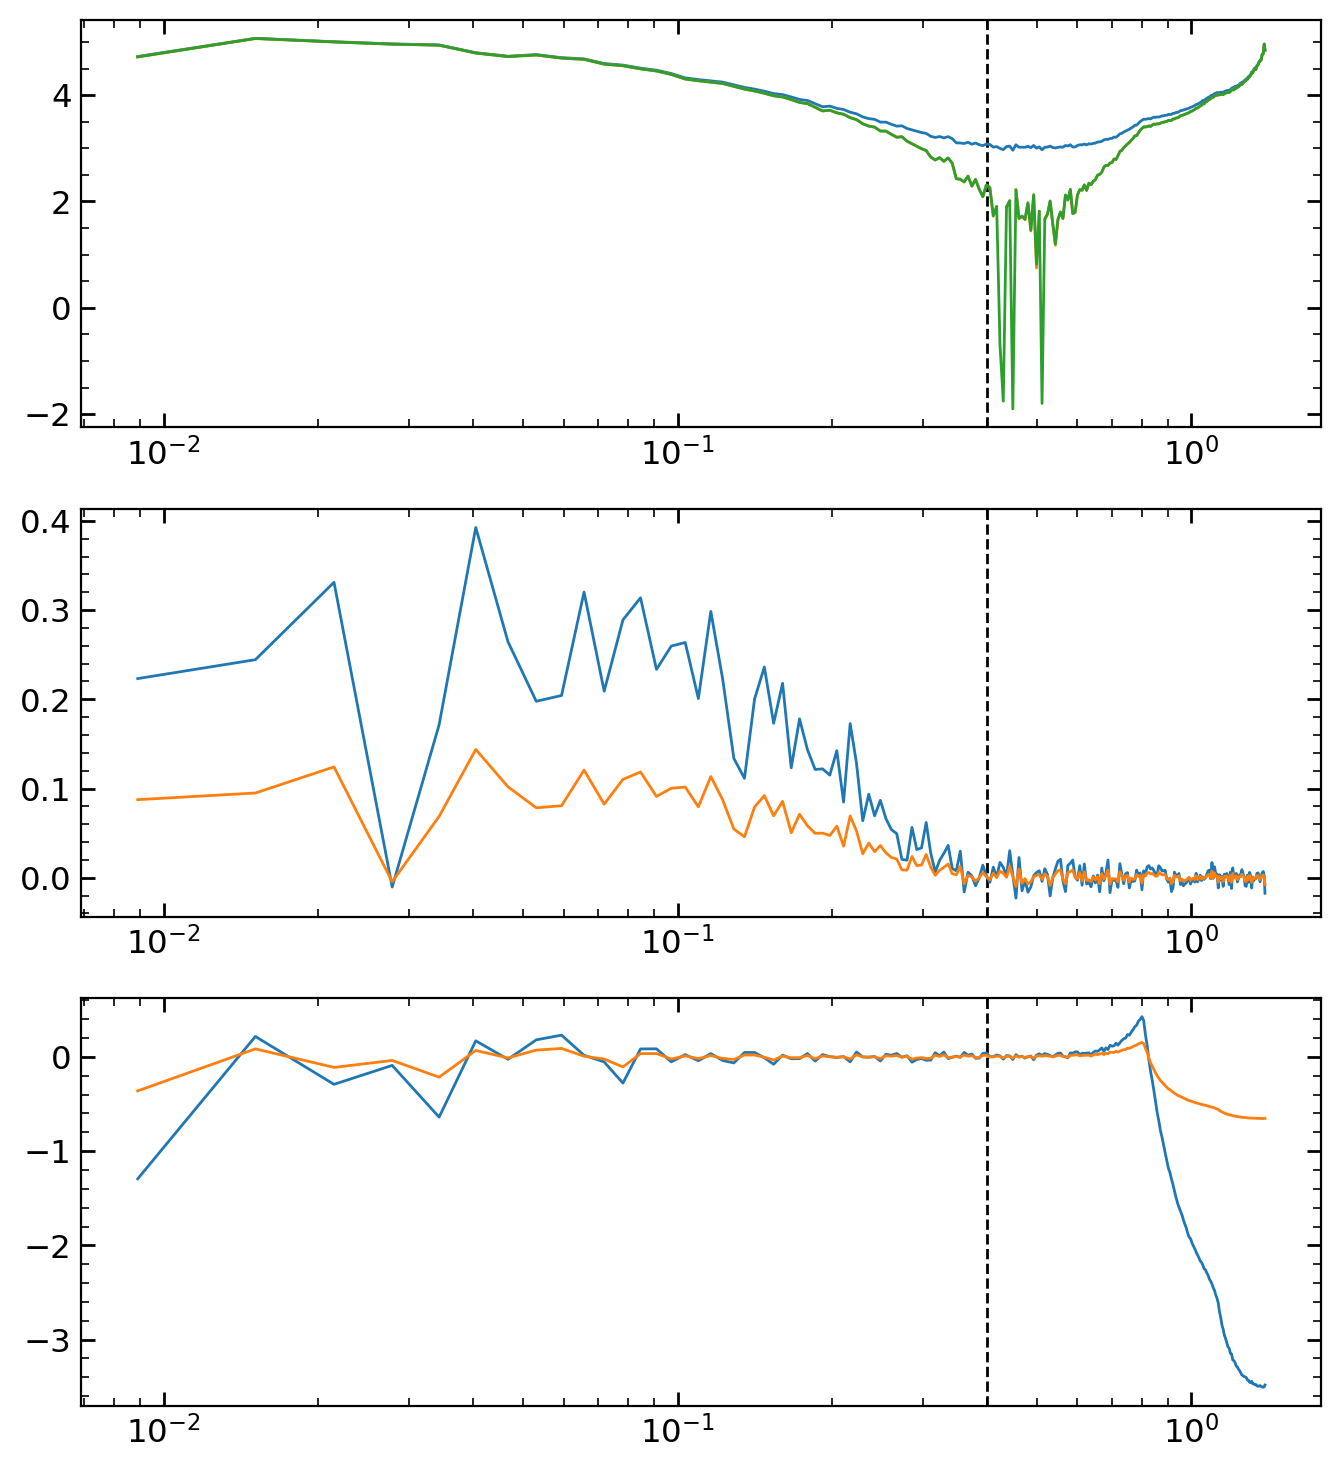

In [10]:
k, v = adiag['Pk_k3D'], adiag['zPk'][:, 0]
v2, v4 = adiag['zPk'][:, 1], adiag['zPk'][:, 2]
nbar = 100_000/(1e3**3)


def signed_log(x, base=10):
    return np.sign(x) * np.log1p(np.abs(x)) / np.log(base)


def tanh_norm(x):
    scale = np.std(x) if np.std(x) > 0 else 1.0
    return np.tanh(x / scale)


f, axs = plt.subplots(3, 1, figsize=(8, 9))
ax = axs[0]
ax.semilogx()
ax.axvline(0.4, color='k', lw=1, ls='--')
ax.plot(k, np.log10(v-(1/nbar)+1000), lw=1)
ax.plot(k, np.log10(v-(1/nbar)), lw=1)
ax.plot(k, signed_log(v-(1/nbar)), lw=1)

ax = axs[1]
ax.semilogx()
ax.axvline(0.4, color='k', lw=1, ls='--')
ax.plot(k, v2/(v), lw=1)
# ax.plot(k, v2/(v-(1/nbar)), lw=1)
ax.plot(k, signed_log(v2/(v)), lw=1)
# ax.set_ylim(-2, 2)

ax = axs[2]
ax.semilogx()
ax.axvline(0.4, color='k', lw=1, ls='--')
ax.plot(k, v4/(v), lw=1)
# ax.plot(k, v2/(v-(1/nbar)), lw=1)
ax.plot(k, signed_log(v4/(v)), lw=1)
# ax.set_ylim(-2, 2)

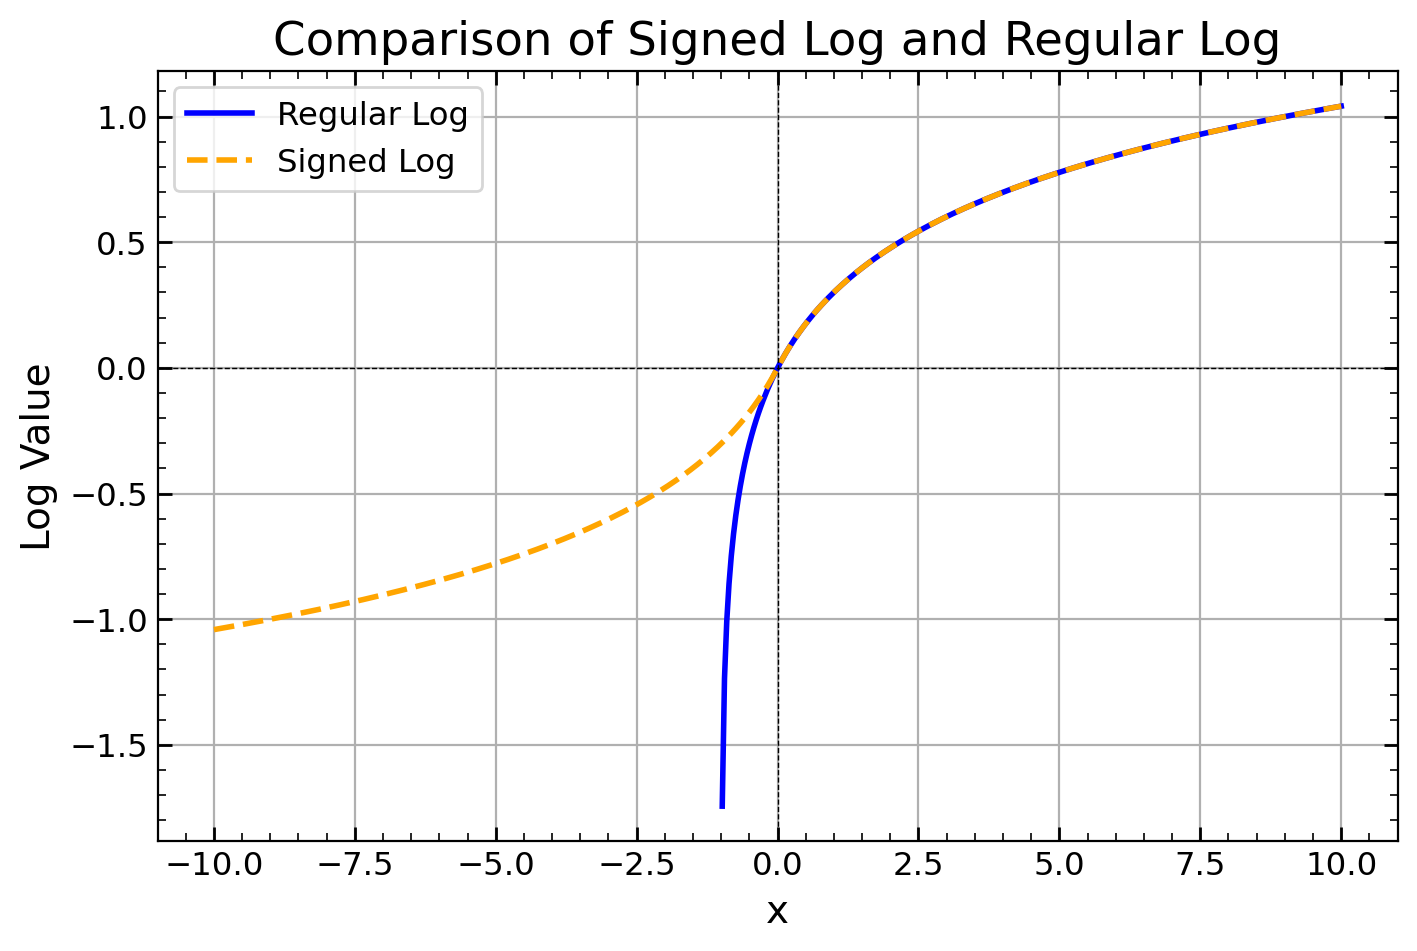

In [11]:
# Range of values including negative and positive
x_values = np.linspace(-10, 10, 500)
# Regular log (log1p for numerical stability)
regular_log = np.log1p(x_values)/np.log(10)
signed_log_values = signed_log(x_values)  # Signed log


def signed_log(x, base=10):
    return np.sign(x) * np.log1p(np.abs(x)) / np.log(base)


plt.figure(figsize=(8, 5))
plt.plot(x_values, regular_log, label='Regular Log', color='blue')
plt.plot(x_values, signed_log_values, label='Signed Log',
         color='orange', linestyle='--')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.legend()
plt.xlabel('x')
plt.ylabel('Log Value')
plt.title('Comparison of Signed Log and Regular Log')
plt.grid()
plt.show()

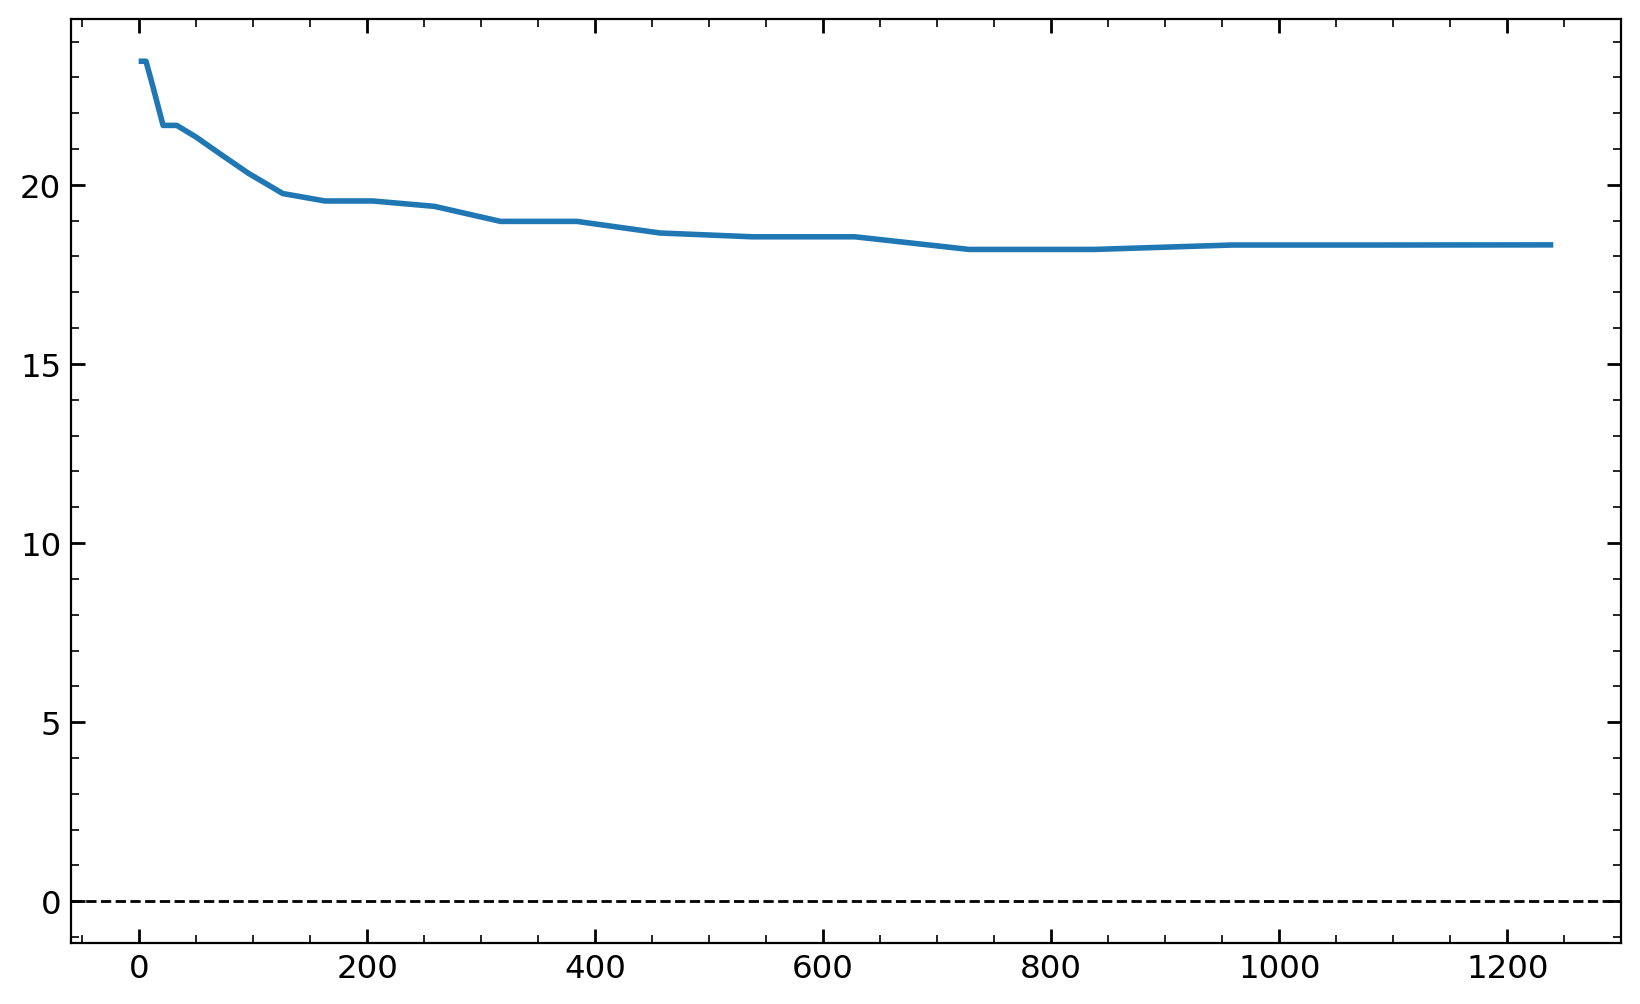

In [85]:
k, v = np.arange(len(adiag['zBk'][0])), adiag['zBk'][0]
k2 = adiag['zBk_k123']
n = adiag['bPk']

m = np.isclose(k2[0], k2[1]) & np.isclose(k2[1], k2[2])
k, v, n = k[m], v[m], n[:, m]
# m = (k2[0] < k2[1]+k2[2]) & (k2[1] < k2[0]+k2[2]) & (k2[2] < k2[0]+k2[1])
# k, v, n = k[m], v[m], n[:, m]

# plt.plot(k, signed_log(v), lw=1)
# plt.plot(k, np.log(v), lw=1)
plt.axhline(0, color='k', lw=1, ls='--')
# plt.plot(k, v - ((1/nbar)*np.sum(n-1./nbar, axis=0) + (1/nbar)**2))
plt.plot(k, np.log(v))
# plt.plot(k, np.log(v - ((1/nbar)*np.sum(n, axis=0) + (1/nbar)**2)))
# plt.plot(k, signed_log(v - ((1/nbar)*(np.sum(n, axis=0)) + (1/nbar)**2)+1e8))

In [28]:
((1/nbar)*np.sum(n, axis=0) + (1/nbar)**2)

array([3.4076805e+09, 2.9574262e+09, 2.7322988e+09, ..., 4.5421155e+08,
       4.5421155e+08, 4.6570547e+08], dtype=float32)